- CURRENT_PATH : 가장 상위 폴더를 지정하면 됩니다.

In [1]:
import os
CURRENT_PATH = os.getcwd()

- 라이브러리 import 및 옵션 설정

In [2]:
import pandas as pd
import numpy as np


from IPython.display import display
from tqdm import tqdm

import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
%matplotlib inline

import re
from datetime import date
from datetime import datetime
from datetime import timedelta

# 데이터프레임에서 실수값 표시 옵션
pd.options.display.float_format = '{:.2f}'.format
# pd.reset_option('display.float_format')

# plot에 한글 폰트 지정
fm.get_fontconfig_fonts()
font_path = CURRENT_PATH + '\\NanumSquareR.ttf'

# 1. 전처리

## 0) data read

In [3]:
df_consumer = pd.read_csv( CURRENT_PATH + "\\'21년 해카톤_고객정보.csv", encoding = 'cp949')
df_car = pd.read_csv( CURRENT_PATH + "\\'21년 해카톤_차량정보.csv", encoding = 'cp949')
df_contact = pd.read_csv( CURRENT_PATH + "\\'21년 해카톤_접촉정보.csv", encoding = 'cp949')

## 1) 고객정보.csv

### (1) 개인사업자 여부(PSN_BIZR_YN) : 결측치를 모두 'N'으로 수정
- 결측치가 아닌 값은 모두 'Y' 입니다. (response ratio : 12.67%)
- 따라서 결측치의 경우는 개인사업자가 아닌 것('N')으로 가정했습니다.

In [4]:
df_consumer.PSN_BIZR_YN.replace(to_replace = np.nan, value = 'N', inplace = True)

### (2) 생년월(TYMD) : 오류 데이터 결측치 처리 및 date 타입으로 형 변환
- 태어난 연도가 2064년, 9999년인 경우는 결측치로 처리했습니다.
- datetime 라이브러리의 datatime.date로 형 변환을 했습니다. (계산상의 이유)

In [5]:
df_consumer.loc[df_consumer.TYMD > 20640000, 'TYMD'] = np.nan

In [6]:
def from_num_to_datetime(x): # 숫자를 date 타입으로 형 변환하는 함수
    x = int(x)
    y, m, d = x // 10000, (x//100) % 100, x % 100
    return date(year = y, month = m, day = max(d, 1))
df_consumer.loc[df_consumer.TYMD.notnull(), 'TYMD'] = df_consumer.loc[df_consumer.TYMD.notnull(), 'TYMD'].map(from_num_to_datetime)

## 2) 차량정보.csv

### (1) 고객ID, 출고일자에 맞춰 정렬
- 하나의 고객 ID 마다 시간 순으로 구매 현황을 파악하고 앞으로의 분리로직을 위해 정렬했습니다.

In [7]:
df_car.sort_values(['CUS_ID', 'WHOT_DT'], inplace = True)
df_car.reset_index(drop = True, inplace = True)

### (2) 출고일자, 보유시작일자, 보유종료일자 모두 date 타입으로 형 변환

In [8]:
df_car.WHOT_DT = df_car.WHOT_DT.map( from_num_to_datetime )
df_car.CAR_HLDG_STRT_DT = df_car.CAR_HLDG_STRT_DT.map( from_num_to_datetime )
df_car.loc[df_car.CAR_HLDG_FNH_DT.notnull(), 'CAR_HLDG_FNH_DT'] = df_car.loc[df_car.CAR_HLDG_FNH_DT.notnull(), 'CAR_HLDG_FNH_DT'].map(from_num_to_datetime)

### (3) 차량등급명1 : '해당없음' -> '승용'으로 수정
- 각 차명(CAR_NM)에 대해서 차량등급명1과 차량등급명2는 1개씩 존재합니다.
- 하지만 차명이 '베르나', '클릭', '쏘나타'인 경우는 모두 차량등급명1이 '승용'과 '해당없음'만 존재하기 때문에 '해당없음'을 '승용'으로 수정했습니다.

In [9]:
df_car.CAR_CGRD_NM_1.replace(to_replace = '해당없음', value = '승용', inplace = True)

# 2. 재구매 유형 로직

## 1) 고객별 섹션 생성
- 섹션이란? 최초구매나 추가구매 이후 일련의 대차 과정을 하나로 묶은 단위
- CUS_CAR_SCTN : 고객 차량 섹션
  - 계산상의 이유로 보유종료일자의 결측치는 2099년 1월 1일로 지정하고 '고객 차량 섹션' 산출 후 다시 결측치로 바꿔줍니다.
  - 각 관측치의 섹션 값은 Section_num 리스트에 저장 후 df_car 데이터에 저장합니다.
  - 기존 보유하던 차량의 보유 종료일부터 standard_period일 전까지의 출고를 '대차'로 정의합니다. (본 분석에서는 standard_period = 30으로 지정)

In [10]:
df_car.CAR_HLDG_FNH_DT.replace(np.nan, date(2099,1,1) , inplace = True)

In [11]:
Section_num, standard_period = [], 30
for i, tmp_data in tqdm(df_car.groupby('CUS_ID')): # 각 고객ID별로 groupby된 데이터 : tmp_data로 사용
    section_FNH_DT = np.array( [ tmp_data.iloc[0].CAR_HLDG_FNH_DT ] ) # 섹션별 보유종료일자 리스트 : section_FNH_DT, 최초구매 데이터로 초기화
    Section_num.append( 1 ) # 최초 구매는 Section 1번으로 지정
    for j in range(1, tmp_data.shape[0]):
        if any( (section_FNH_DT - timedelta(days = standard_period) <= tmp_data.iloc[j].WHOT_DT )): # 이전 섹션의 (보유종료일자 - standard_period일) 이후의 출고는 대차로 지정
            # 이전 섹션들 중 하나라도 대차일 후보가 정해지는 경우, 출고일자와 보유종료일자가 가장 가까운 섹션에 대차로 분류
            tmp = section_FNH_DT[:] # 섹션별 보유종료일자 리스트 복사 후 출고일자와의 차이값 데이터 생성
            tmp = np.array( [abs(x.days) for x in (tmp - tmp_data.iloc[j].WHOT_DT)] )
            tmp[ (section_FNH_DT - timedelta(days = standard_period) > tmp_data.iloc[j].WHOT_DT ) ] = max(tmp) + 1 # (보유종료일자 - standard_period일) 이후의 출고인 섹션만 보기 위해서 나머지는 모두 최댓값 처리
            section_num = np.argmin(tmp) # 출고일자와 가장 가까운 보유종료일자를 가진 섹션 산출
            section_FNH_DT[ section_num ] = tmp_data.iloc[j].CAR_HLDG_FNH_DT # 섹션별 보유종료일자 리스트 최신화
            Section_num.append( section_num + 1 ) # 해당 관측치에 대해 섹션 추가
        else: # 이전 섹션들 중 하나라도 대차일 후보가 없는 경우, 추가구매로 분류
            section_FNH_DT = np.append( section_FNH_DT, tmp_data.iloc[j].CAR_HLDG_FNH_DT ) # 추가구매의 경우 섹션별 보유종료일자 리스트에 새로운 섹션 추가
            Section_num.append( len(section_FNH_DT) ) # 추가된 Section은 가장 마지막이므로 len 함수를 이용하여 지정

100%|██████████████████████████████████████████████████████████████████████| 1096206/1096206 [05:09<00:00, 3544.18it/s]


In [12]:
df_car.CAR_HLDG_FNH_DT.replace(date(2099,1,1), np.nan , inplace = True)

In [13]:
df_car['CUS_CAR_SCTN'] = Section_num
del Section_num

## 2) 고객 차량 섹션을 이용한 분리 로직
- 각 고객별 섹션에서의 첫 구매는 추가구매이고 그 이후는 모두 대차입니다.
- 단, 1섹션에서의 첫 구매는 최초구매입니다.

### (1) 고객ID, 고객 차량 섹션, 출고일자 기준으로 정렬합니다.

In [14]:
df_car.sort_values(['CUS_ID','CUS_CAR_SCTN','WHOT_DT'], inplace = True)

### (2) 각 고객별 섹션 내 구매 순서를 생성합니다.

In [15]:
num_in_Section = []
for i, tmp_data in tqdm(df_car.groupby(['CUS_ID','CUS_CAR_SCTN'])):
    num_in_Section.extend( range(1,tmp_data.shape[0]+1) )

100%|█████████████████████████████████████████████████████████████████████| 1390458/1390458 [00:27<00:00, 50277.59it/s]


In [16]:
df_car['NUM_IN_SECTION'] = num_in_Section
del num_in_Section

### (3) 섹션 내 구매 순서가 1인 경우는 모두 추가구매(1), 아닌 경우는 대차(0)로 구분합니다.
- 재구매 유형(Y) : 0일 경우 '대차', 1일 경우 '추가구매', 2일 경우 '최초구매'인 범주형 변수

In [17]:
df_car['REPURCHASE_TYPE'] = 0

In [18]:
df_car.loc[df_car.NUM_IN_SECTION == 1, 'REPURCHASE_TYPE'] = 1

### (4) 섹션 내 구매 순서가 1이면서 섹션 번호도 1인 경우는 최초구매(2)로 분리합니다.

In [19]:
df_car.loc[(df_car.NUM_IN_SECTION == 1) & (df_car.CUS_CAR_SCTN == 1), 'REPURCHASE_TYPE'] = 2

- 예측 모델링을 위해 차량정보 데이터를 저장합니다. (필요하면 주석 제거 후 사용)

In [20]:
df_car.to_csv(CURRENT_PATH + '\\new_해카톤_차량정보.csv', index = False, encoding = 'cp949')

# 3. EDA

## 1) 고객정보와 차량정보 데이터 병합 : rdata

In [21]:
rdata = pd.merge( df_car, df_consumer.loc[:,['CUS_ID','PSN_BIZR_YN','SEX_SCN_NM','TYMD']] , on = 'CUS_ID' )
rdata.sort_values(['CUS_ID','WHOT_DT'], inplace = True)

- BUY_NUM : 구매순서
- TOTAL_BUY_NUM : 총구매개수

In [22]:
tmp, tmp1 = [], []
for i, j in tqdm(rdata.groupby('CUS_ID').CUS_ID):
    k = len(j)
    tmp.extend( range(1, k+1) )
    tmp1.append( k )

rdata['BUY_NUM'] = tmp
rdata['TOTAL_BUY_NUM'] = np.repeat(tmp1, tmp1)

100%|█████████████████████████████████████████████████████████████████████| 1096206/1096206 [00:22<00:00, 48882.34it/s]


- BUY_INTERVAL : 구매간격 (단위 : 일)

In [23]:
tmp = np.array( list(map(lambda x : x.days, (rdata.WHOT_DT[1:].reset_index(drop = True) - rdata.CAR_HLDG_FNH_DT[:-1]))) )
tmp = np.append( [np.nan], tmp)
rdata['BUY_INTERVAL'] = tmp
rdata.loc[rdata.BUY_NUM == 1, 'BUY_INTERVAL'] = np.nan

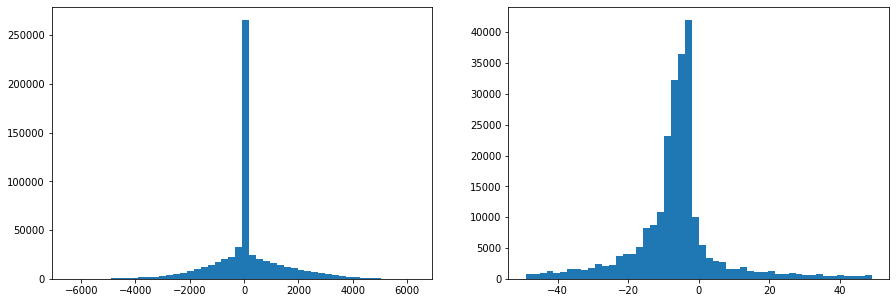

In [27]:
plt.figure(figsize = (15,5))
plt.subplot(121)
plt.hist(rdata.BUY_INTERVAL, bins = 50)

plt.subplot(122)
plt.hist(rdata.BUY_INTERVAL[(-50 < rdata.BUY_INTERVAL) & (rdata.BUY_INTERVAL < 50)], bins = 50)

plt.show()

# plt.figure(figsize = (20,15))
# plt.subplot(322)
# plt.hist(rdata.BUY_INTERVAL[(-30 < rdata.BUY_INTERVAL) & (rdata.BUY_INTERVAL < 30)], bins = 50)
    
# plt.subplot(323)
# plt.hist(rdata.BUY_INTERVAL[(-50 < rdata.BUY_INTERVAL) & (rdata.BUY_INTERVAL < 50)], bins = 50)

# plt.subplot(324)
# plt.hist(rdata.BUY_INTERVAL[(-100 < rdata.BUY_INTERVAL) & (rdata.BUY_INTERVAL < 100)], bins = 50)

# plt.subplot(325)
# plt.hist(rdata.BUY_INTERVAL[(-10 < rdata.BUY_INTERVAL) & (rdata.BUY_INTERVAL < 0)], bins = 50)

# plt.subplot(326)
# plt.hist(rdata.BUY_INTERVAL[(100 < rdata.BUY_INTERVAL)], bins = 50)

# plt.show()

- CAR_HAVE_PERIOD : 차량보유기간 (단위 : 개월수)
  - 차량보유기간 = 보유종료일자 - 출고일자

In [28]:
print( rdata.WHOT_DT.min(), rdata.WHOT_DT.max() )
print( min( rdata.loc[rdata.CAR_HLDG_FNH_DT.notnull(), 'CAR_HLDG_FNH_DT' ] ), max( rdata.loc[rdata.CAR_HLDG_FNH_DT.notnull(), 'CAR_HLDG_FNH_DT' ] ) )

2000-01-04 2017-12-29
2000-05-29 2017-12-30


In [29]:
tmp = (rdata.CAR_HLDG_FNH_DT - rdata.WHOT_DT).map(lambda x: x.days).values
tmp_minus_idx = tmp < 0
tmp = abs(tmp)
tmp = (tmp // 365) * 12 + (tmp % 365) // 30 + 1
tmp[tmp_minus_idx] = - tmp[tmp_minus_idx]

rdata['CAR_HAVE_PERIOD'] = tmp

C:\Users\gijo0\.conda\envs\tf_cpu\lib\site-packages\ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in floor_divide
  after removing the cwd from sys.path.
C:\Users\gijo0\.conda\envs\tf_cpu\lib\site-packages\ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in remainder
  after removing the cwd from sys.path.


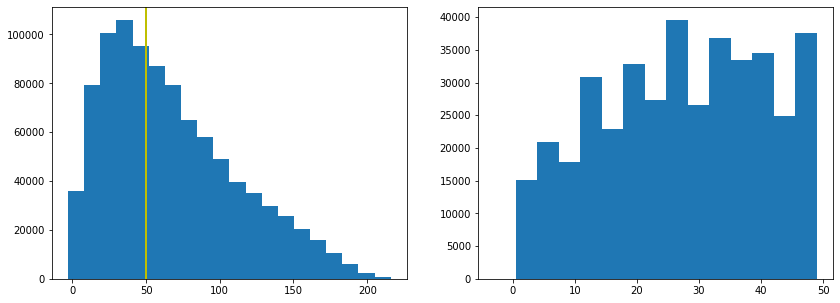

In [30]:
plt.figure(figsize = (14,5))

plt.subplot(121)
plt.hist(rdata.CAR_HAVE_PERIOD, bins = 20)
plt.axvline(x=50, color='y', linewidth = 2)

plt.subplot(122)
plt.hist(rdata.CAR_HAVE_PERIOD[rdata.CAR_HAVE_PERIOD < 50], bins =15)

plt.show()

- '대차'인 경우와 '추가구매'인 경우에 차량보유기간의 차이가 있음을 알 수 있다.
- '추가구매'의 경우 차량 보유기간이 더 길고

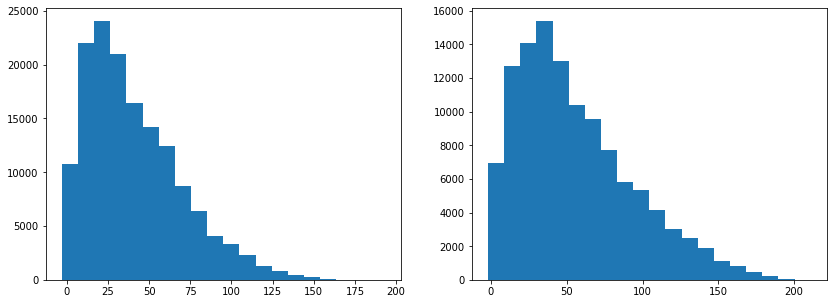

In [33]:
plt.figure(figsize = (14,5))

plt.subplot(121)
plt.hist(rdata.loc[rdata.REPURCHASE_TYPE == 0,'CAR_HAVE_PERIOD'], bins = 20)

plt.subplot(122)
plt.hist(rdata.loc[rdata.REPURCHASE_TYPE == 1,'CAR_HAVE_PERIOD'], bins = 20)

plt.show()

In [32]:
rdata.head()

,CAR_ID,CUS_ID,WHOT_DT,CAR_HLDG_STRT_DT,CAR_HLDG_FNH_DT,CAR_NM,CAR_CGRD_NM_1,CAR_CGRD_NM_2,CAR_ENG_NM,CAR_TRIM_NM,CUS_CAR_SCTN,NUM_IN_SECTION,REPURCHASE_TYPE,PSN_BIZR_YN,SEX_SCN_NM,TYMD,BUY_NUM,TOTAL_BUY_NUM,BUY_INTERVAL,CAR_HAVE_PERIOD
0,H1308031441VP6U069690,AONEEOO010000113,2006-06-27,2006-06-27,2007-07-12,베르나,승용,소형,2007이전 데이터,2007이전 데이터,1,1,2,N,남자,1955-03-01,1,2,NaN,13.00
1,H1308060741EBBA077034,AONEEOO010000113,2011-08-01,2011-08-01,NaN,그랜저HG,승용,대형,가솔린 3.0,노블,1,2,0,N,남자,1955-03-01,2,2,1481.00,NaN
2,H1308052141BP5A053834,AONEEOO020000165,2005-02-26,2005-02-26,NaN,쏘나타,승용,중형,2007이전 데이터,2007이전 데이터,1,1,2,Y,남자,1951-10-01,1,2,NaN,NaN
3,H1308070241ABAU090781,AONEEOO020000165,2010-01-06,2010-01-06,NaN,제네시스,승용,대형,가솔린 3.3,Luxury,2,1,1,Y,남자,1951-10-01,2,2,NaN,NaN
4,H1308190381PP1U052991,AONEEOO020000170,2001-01-11,2001-01-11,2011-06-08,싼타페,RV,중형SUV,2007이전 데이터,2007이전 데이터,1,1,2,N,남자,1952-04-01,1,2,NaN,126.00


- WHOT_AGE : 출고일자기준 만나이

In [19]:
tmp = np.array( list(map(lambda x : x.days, (rdata.WHOT_DT - rdata.TYMD))) )
rdata['WHOT_AGE'] = (tmp // 365.25)

C:\Users\gijo0\.conda\envs\tf_cpu\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in floor_divide
  
